### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
#!pip install tensorflow_decision_forests

## ライブラリをインポート

--
TensorFlowとその他データ分析で使用するライブラリをインポートする

In [2]:
# TensorFlow
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# Other
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

2023-09-19 07:23:53.429392: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 07:23:53.489597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 07:23:53.490970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 07:23:54.770551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Check version
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


### データ取り込み

--
アメリカ アイオワ州戸建て住宅の価格データをデータセットとして用いる

In [4]:
# train.csv file read
train_file_path = './dataset/AIML_HousePrices/train.csv'
dataset_df = pd.read_csv(train_file_path)

In [5]:
print('Training用のデータセットの数は {}'.format(dataset_df.shape))

Training用のデータセットの数は (1460, 81)


In [6]:
dataset_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### データ前処理
----

--ID列を削除

In [7]:
# drop Id column
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### データ分析(簡略化ver)

--数値データの全体像を把握します。

--SalePriceの全体像の把握

<function matplotlib.pyplot.show(close=None, block=None)>

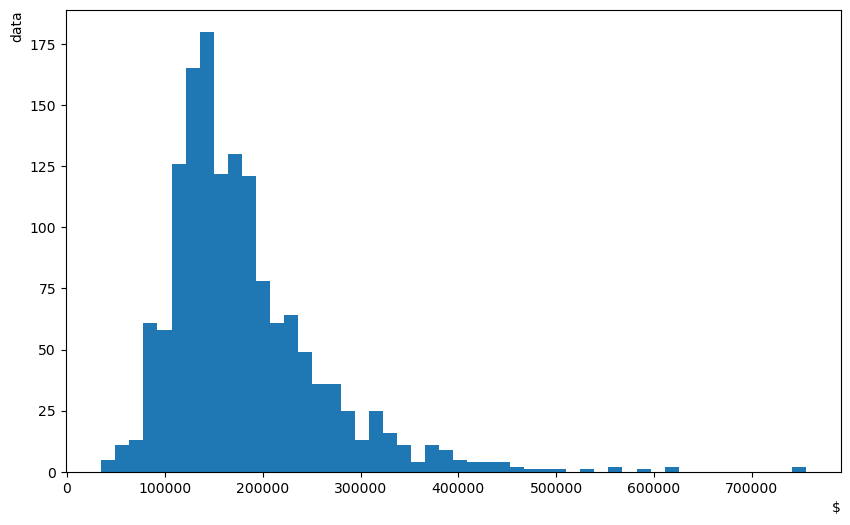

In [9]:
plt.figure(figsize=(10,6))
plt.hist(dataset_df['SalePrice'], bins=50)
plt.xlabel('$', loc='right')
plt.ylabel('data', loc='top')
plt.show

--データの可視化


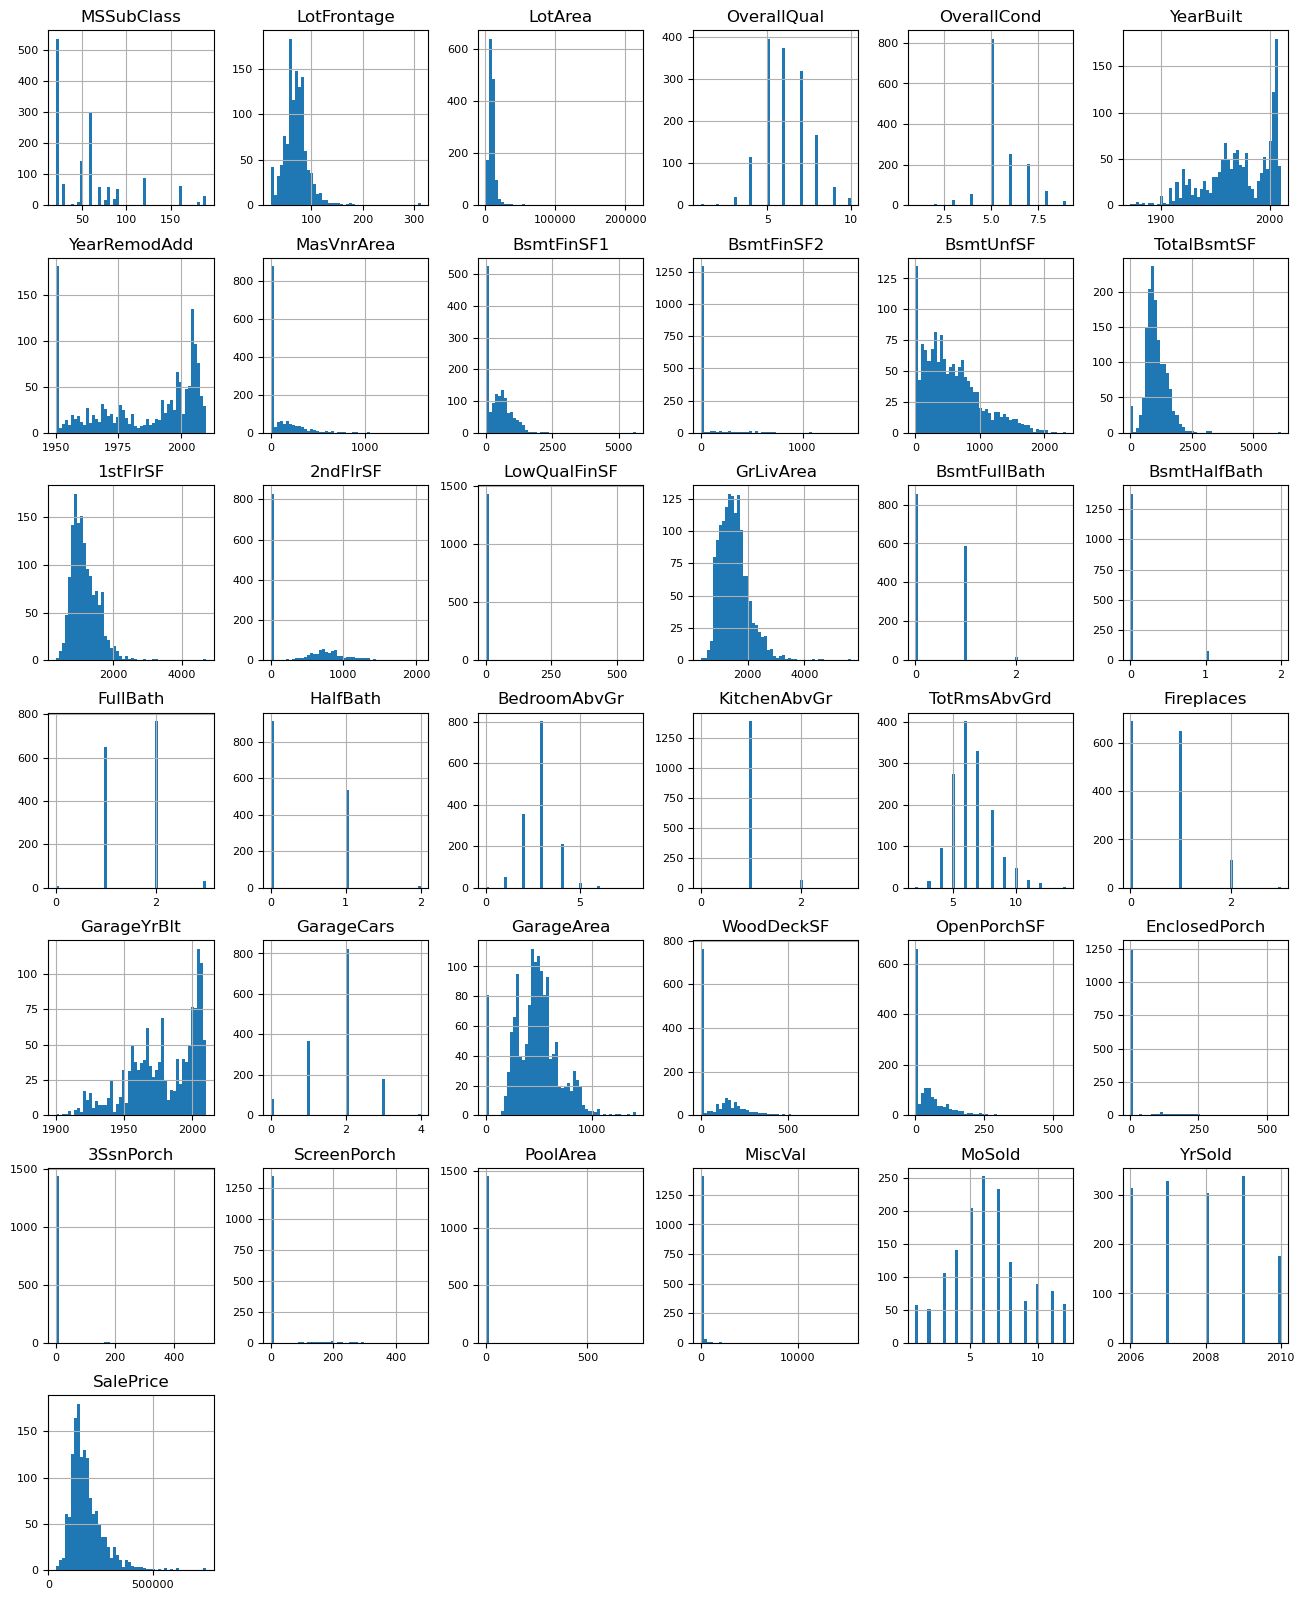

In [10]:
df_num = dataset_df.select_dtypes(exclude=['object'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### モデル学習
----

--
トレーニング用データセットと検証用データセットに分割

In [11]:
# data split
def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

In [12]:
train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("トレーニング用データ {}, 検証用データ {} ".format(
    len(train_ds_pd), len(valid_ds_pd)))

トレーニング用データ 1037, 検証用データ 423 


--PandasのデータフレームをTensorFlow用のデータ型に変換

In [13]:
# Convert the dataset
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label = label, task = tfdf.keras.Task.REGRESSION)

### モデルを構築
----

--機械学習のアルゴリズム"ランダムフォレスト"を使用する

In [14]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmpu97bdymc as temporary training directory


In [15]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:05.535765. Found 1037 examples.
Training model...


[INFO 23-09-19 07:24:11.2402 UTC kernel.cc:1243] Loading model from path /tmp/tmpu97bdymc/model/ with prefix 3d90e1a020884754
[INFO 23-09-19 07:24:11.4246 UTC decision_forest.cc:660] Model loaded with 300 root(s), 98552 node(s), and 74 input feature(s).
[INFO 23-09-19 07:24:11.4246 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-19 07:24:11.4247 UTC kernel.cc:1075] Use fast generic engine


Model trained in 0:00:03.205879
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


--
ランダムフォレストの決定木モデルを図に表示

In [38]:
# Visualize the model
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

### モデル分析/検証
----

In [17]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1037, accuracy=None, loss=None, rmse=28041.689133109365, ndcg=None, aucs=None, auuc=None, qini=None)

--平均二乗誤差(MSE)の計算

In [18]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 547ms/step - loss: 0.0000e+00 - mse: 920617280.0000
loss: 0.0000
mse: 920617280.0000


--
目的変数(SalePrice)に影響を与えている列名

In [19]:
# Variable Importances
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


In [20]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 111.0),
 ("ExterQual" (4; #22), 69.0),
 ("Neighborhood" (4; #59), 40.0),
 ("GarageCars" (1; #32), 28.0),
 ("GrLivArea" (1; #38), 23.0),
 ("KitchenQual" (4; #44), 10.0),
 ("GarageArea" (1; #31), 6.0),
 ("YearBuilt" (1; #76), 4.0),
 ("BsmtQual" (4; #14), 3.0),
 ("TotalBsmtSF" (1; #73), 3.0),
 ("GarageYrBlt" (1; #37), 2.0),
 ("1stFlrSF" (1; #0), 1.0)]

### モデルを
----

In [21]:
# Prediction dataset
test_file_path = './dataset/AIML_HousePrices/test.csv'
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

In [22]:
# prediction
preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})
output.head()

2/2 [==============================] - 1s 21ms/step


,Id,SalePrice
0,1461,126291.875000
1,1462,149822.031250
2,1463,178869.640625
3,1464,183020.359375
4,1465,201994.218750


----
## 機械学習サイクル 2週目
----

### データ前処理
----

In [23]:
# train.csv file read
train_file_path_2 = './dataset/AIML_HousePrices/train.csv'
dataset_df2 = pd.read_csv(train_file_path_2)

# drop Id column
dataset_df2 = dataset_df2.drop('Id', axis=1)
dataset_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

--
欠損値補完

In [24]:
# Missing Value Filling
dataset_df2["PoolQC"] = dataset_df2["PoolQC"].fillna("None")
dataset_df2["MiscFeature"] = dataset_df2["MiscFeature"].fillna("None")
dataset_df2["Alley"] = dataset_df2["Alley"].fillna("None")
dataset_df2["Fence"] = dataset_df2["Fence"].fillna("None")
dataset_df2["FireplaceQu"] = dataset_df2["FireplaceQu"].fillna("None")

--
データ列の追加 \
1:住宅が販売されるまでの年数 \
2:修理が行われるまでの年数 \
3:総フロア面積 \
4:ガレージに関する特徴量 \
5:リモデルされたか

In [25]:
# Add Clumns
dataset_df2.loc[:, 'YearsBeforeSale'] = dataset_df2['YrSold'] - dataset_df2['YearBuilt']
dataset_df2.loc[:, 'YearsSinceRemodel'] = dataset_df2['YrSold'] - dataset_df2['YearRemodAdd']
dataset_df2.loc[:, 'TotalSF'] = dataset_df2['TotalBsmtSF'] + dataset_df2['1stFlrSF'] + dataset_df2['2ndFlrSF']
dataset_df2.loc[:, 'GarageAreaPerCar'] = dataset_df2['GarageArea'] / (dataset_df2['GarageCars'] + 1)
dataset_df2.loc[:, 'Remodeled'] = (dataset_df2['YearBuilt'] != dataset_df2['YearRemodAdd']).astype(int)

dataset_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 85 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int64  
 1   MSZoning           1460 non-null   object 
 2   LotFrontage        1201 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   Street             1460 non-null   object 
 5   Alley              1460 non-null   object 
 6   LotShape           1460 non-null   object 
 7   LandContour        1460 non-null   object 
 8   Utilities          1460 non-null   object 
 9   LotConfig          1460 non-null   object 
 10  LandSlope          1460 non-null   object 
 11  Neighborhood       1460 non-null   object 
 12  Condition1         1460 non-null   object 
 13  Condition2         1460 non-null   object 
 14  BldgType           1460 non-null   object 
 15  HouseStyle         1460 non-null   object 
 16  OverallQual        1460 

### モデル学習
----

--
トレーニング用データセットと検証用データセットに分割

In [26]:
train_ds_pd2, valid_ds_pd2 = split_dataset(dataset_df2)
print("トレーニング用データ {}, 検証用データ {} ".format(
    len(train_ds_pd2), len(valid_ds_pd2)))

トレーニング用データ 1038, 検証用データ 422 


In [27]:
# Convert the dataset
label = 'SalePrice'
train_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd2, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd2, label = label, task = tfdf.keras.Task.REGRESSION)

### モデルを構築
----

--"ランダムフォレスト"というアルゴリズムを使用

In [28]:
rf2 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf2.compile(metrics=["mse"])

Use /tmp/tmpsz3a76it as temporary training directory


In [29]:
rf2.fit(x=train_ds2)

Reading training dataset...
Training dataset read in 0:00:00.839887. Found 1038 examples.
Training model...
Model trained in 0:00:02.433063
Compiling model...


[INFO 23-09-19 07:24:19.2605 UTC kernel.cc:1243] Loading model from path /tmp/tmpsz3a76it/model/ with prefix bc2f6e21f1d343ea
[INFO 23-09-19 07:24:19.4467 UTC decision_forest.cc:660] Model loaded with 300 root(s), 98856 node(s), and 80 input feature(s).
[INFO 23-09-19 07:24:19.4467 UTC kernel.cc:1075] Use fast generic engine


Model compiled.


In [30]:
# Visualize the model
tfdf.model_plotter.plot_model_in_colab(rf2, tree_idx=0, max_depth=3)

### モデル分析/検証
----

In [31]:
inspector2 = rf2.make_inspector()
inspector2.evaluation()

Evaluation(num_examples=1038, accuracy=None, loss=None, rmse=27768.3403237058, ndcg=None, aucs=None, auuc=None, qini=None)

--平均二乗誤差(MSE)の計算

In [32]:
evaluation2 = rf2.evaluate(x=valid_ds2,return_dict=True)

for name, value in evaluation2.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 332ms/step - loss: 0.0000e+00 - mse: 933153344.0000
loss: 0.0000
mse: 933153344.0000


--
1周目と２週目の平均絶対誤差を比較

In [33]:
print(f" 1st Cycle: {evaluation['mse']}\n 2nd Cycle: {evaluation2['mse']}")

 1st Cycle: 920617280.0
 2nd Cycle: 933153344.0


In [34]:
inspector2.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #63), 103.0),
 ("TotalSF" (1; #76), 63.0),
 ("GarageCars" (1; #33), 36.0),
 ("ExterQual" (4; #22), 35.0),
 ("Neighborhood" (4; #60), 20.0),
 ("YearsBeforeSale" (1; #81), 11.0),
 ("YearBuilt" (1; #79), 8.0),
 ("BsmtQual" (4; #14), 7.0),
 ("GarageArea" (1; #31), 7.0),
 ("TotalBsmtSF" (1; #75), 4.0),
 ("1stFlrSF" (1; #0), 3.0),
 ("GrLivArea" (1; #39), 2.0),
 ("KitchenQual" (4; #45), 1.0)]

### モデルデプロイ
----

In [35]:
# Prediction dataset
test_file_path2 = './dataset/AIML_HousePrices/test.csv'
test_data2 = pd.read_csv(test_file_path2)
ids2 = test_data2.pop('Id')

# Missing Value Filling
test_data2["PoolQC"] = test_data2["PoolQC"].fillna("None")
test_data2["MiscFeature"] = test_data2["MiscFeature"].fillna("None")
test_data2["Alley"] = test_data2["Alley"].fillna("None")
test_data2["Fence"] = test_data2["Fence"].fillna("None")
test_data2["FireplaceQu"] = test_data2["FireplaceQu"].fillna("None")

# Add Clumns
test_data2.loc[:, 'YearsBeforeSale'] = test_data2['YrSold'] - test_data2['YearBuilt']
test_data2.loc[:, 'YearsSinceRemodel'] = test_data2['YrSold'] - test_data2['YearRemodAdd']
test_data2.loc[:, 'TotalSF'] = test_data2['TotalBsmtSF'] + test_data2['1stFlrSF'] + test_data2['2ndFlrSF']
test_data2.loc[:, 'GarageAreaPerCar'] = test_data2['GarageArea'] / (test_data2['GarageCars'] + 1)
test_data2.loc[:, 'Remodeled'] = (test_data2['YearBuilt'] != test_data2['YearRemodAdd']).astype(int)

test_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data2,
    task = tfdf.keras.Task.REGRESSION)

In [36]:
# prediction
preds2 = rf2.predict(test_ds2)
output2 = pd.DataFrame({'Id': ids2, 'SalePrice': preds2.squeeze()})
output2.head()

2/2 [==============================] - 1s 20ms/step


,Id,SalePrice
0,1461,123195.796875
1,1462,152914.640625
2,1463,188236.093750
3,1464,184299.562500
4,1465,194007.875000


In [37]:
# 1st Cycle prediction
output.head()

,Id,SalePrice
0,1461,126291.875000
1,1462,149822.031250
2,1463,178869.640625
3,1464,183020.359375
4,1465,201994.218750


In [39]:
# Submit
sample_submission_df = pd.read_csv('./dataset/AIML_HousePrices/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('./submit/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 23ms/step


,Id,SalePrice
0,1461,126291.875000
1,1462,149822.031250
2,1463,178869.640625
3,1464,183020.359375
4,1465,201994.218750


In [40]:
# Submit2
sample_submission_df2 = pd.read_csv('./dataset/AIML_HousePrices/sample_submission.csv')
sample_submission_df2['SalePrice'] = rf2.predict(test_ds2)
sample_submission_df2.to_csv('./submit/submission2.csv', index=False)
sample_submission_df2.head()

2/2 [==============================] - 0s 21ms/step


,Id,SalePrice
0,1461,123195.796875
1,1462,152914.640625
2,1463,188236.093750
3,1464,184299.562500
4,1465,194007.875000
